In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Autoregressive Linear Regression on just Blood Glucose

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load the data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

In [3]:
# Preprocess - Round to nearest 5 minutes
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')

# Filter out rows where mg/dl is > 400 or missing values
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])

# Drop duplicates and sort
cgm_data = cgm_data.drop_duplicates(subset='date').reset_index(drop=True)
cgm_data = cgm_data.sort_values(by='date').reset_index(drop=True)

In [4]:
# Generate AR Features (using past 12 readings as input)
num_lags = 12 # Using the past 12 values
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

cgm_data = cgm_data.dropna().reset_index(drop=True)

In [5]:
# Split into train/test (80% train, 20% test by time order)
train_size = int(len(cgm_data) * 0.8)
train_data = cgm_data[:train_size]
test_data = cgm_data[train_size:]

In [6]:
# Define function to train and evaluate for different time steps
def train_ar_model(data, target_step):
    # Prepare inputs (X) and target (y)
    X = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Use np.sqrt on MSE

    # Display the coefficients
    coefficients = model.coef_
    intercept = model.intercept_

    print("Linear Regression Coefficients (lags):")
    for i, coef in enumerate(coefficients, start=1):
      print(f"Lag {i}: {coef:.4f}")
    print(f"Intercept: {intercept:.4f}")

    return model, rmse

In [7]:
# Train models for different time step targets and evaluate
time_steps = [3, 6, 9, 12]  # Corresponding to 15, 30, 45, 60 minutes
results = {}

for step in time_steps:
    model, rmse = train_ar_model(cgm_data, step)
    results[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"Time step {step} (predicting {step*5} minutes ahead) - RMSE: {rmse:.4f}")

# Results dictionary now contains trained models and RMSE for each time target

Linear Regression Coefficients (lags):
Lag 1: 1.5483
Lag 2: -0.2848
Lag 3: -0.1474
Lag 4: -0.0769
Lag 5: -0.0193
Lag 6: -0.0248
Lag 7: -0.0243
Lag 8: -0.0207
Lag 9: -0.0121
Lag 10: -0.0036
Lag 11: -0.0010
Lag 12: -0.0100
Intercept: 13.6443
Time step 3 (predicting 15 minutes ahead) - RMSE: 18.8309
Linear Regression Coefficients (lags):
Lag 1: 1.6500
Lag 2: -0.3433
Lag 3: -0.1875
Lag 4: -0.1063
Lag 5: -0.0357
Lag 6: -0.0331
Lag 7: -0.0313
Lag 8: -0.0271
Lag 9: -0.0151
Lag 10: -0.0043
Lag 11: 0.0006
Lag 12: -0.0158
Intercept: 26.5293
Time step 6 (predicting 30 minutes ahead) - RMSE: 28.8924
Linear Regression Coefficients (lags):
Lag 1: 1.6425
Lag 2: -0.3706
Lag 3: -0.2004
Lag 4: -0.1151
Lag 5: -0.0428
Lag 6: -0.0371
Lag 7: -0.0331
Lag 8: -0.0260
Lag 9: -0.0207
Lag 10: -0.0072
Lag 11: -0.0015
Lag 12: -0.0121
Intercept: 39.9206
Time step 9 (predicting 45 minutes ahead) - RMSE: 36.9419
Linear Regression Coefficients (lags):
Lag 1: 1.5697
Lag 2: -0.3695
Lag 3: -0.1997
Lag 4: -0.1142
Lag 5: -0

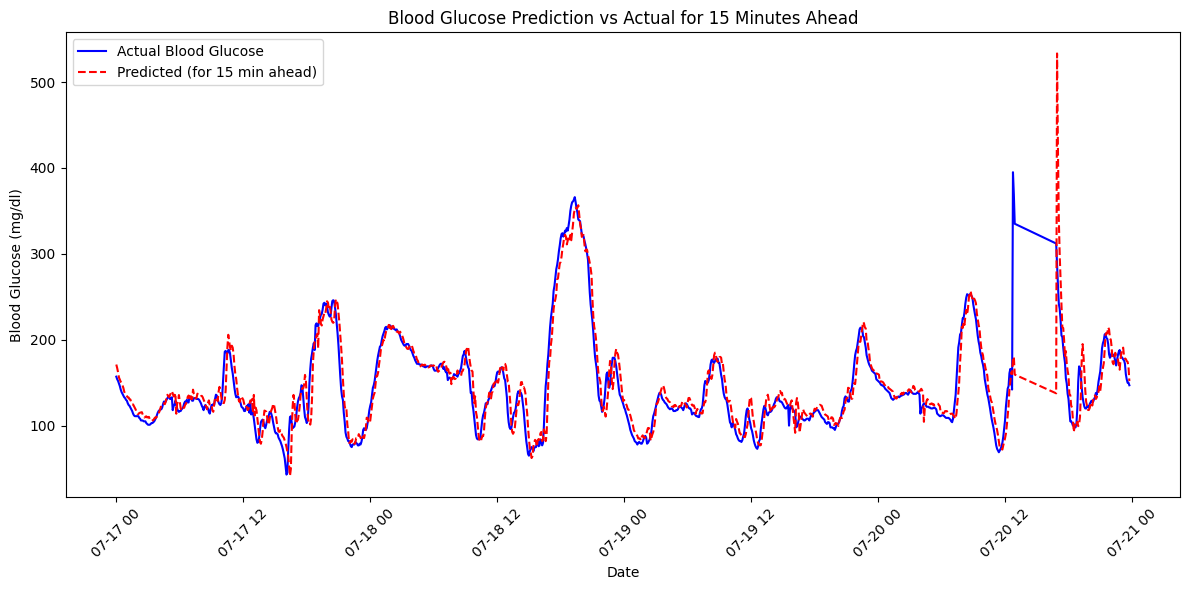

In [8]:
import matplotlib.pyplot as plt

# Function to make predictions for a specific week and plot them
def plot_predictions_for_week(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Predicted (for {target_step*5} min ahead)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Replace with desired dates
start_date = '2021-07-17'
end_date = '2021-07-21'
plot_predictions_for_week(cgm_data[train_size:], results['15 min ahead']['Model'], 3, start_date, end_date)


ARX Model with Blood Glucose and Bolus Data

In [ ]:
# Load Bolus data
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')

# Preprocess Bolus data - Round to nearest 5 minutes and fill missing values with 0
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)  # Set missing values to 0

# Merge Bolus data with CGM data on date
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)  # Fill missing values after merge

# Generate lag features for Bolus variables
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput', 'recommended.carb', 'recommended.net',
              'recommended.correction', 'insulinSensitivityFactor', 'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

# Drop rows with NaNs introduced by shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Update train/test split based on merged data
train_data = merged_data[:train_size]
test_data = merged_data[train_size:]

<ipython-input-9-04aca2ebd074>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-9-04aca2ebd074>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-9-04aca2ebd074>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

In [ ]:
# Modify train_ar_model function to include all lagged features
def train_arx_model(data, target_step):
    # Prepare inputs (X) - using lag features from both mg/dl and Bolus data
    lag_columns = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
                  [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
    X = data[lag_columns].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Extract coefficients and intercept
    coefficients = model.coef_
    intercept = model.intercept_

    # Display the coefficients
    print("Linear Regression Coefficients (ARX Model):")
    feature_names = merged_data.drop(columns=['date', 'mg/dl']).columns
    for feature, coef in zip(feature_names, coefficients):
      print(f"{feature}: {coef:.4f}")
    print(f"Intercept: {intercept:.4f}")

    return model, rmse

In [ ]:
# Modify train_arx_model function to include all lagged features
import matplotlib.pyplot as plt
import numpy as np

def train_arx_model(data, target_step):
    # Prepare inputs (X) - using lag features from both mg/dl and Bolus data
    lag_columns = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
                  [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
    X = data[lag_columns].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Extract coefficients and intercept
    coefficients = model.coef_
    intercept = model.intercept_

    # Display the coefficients
    print("Linear Regression Coefficients (ARX Model):")
    feature_names = merged_data.drop(columns=['date', 'mg/dl']).columns
    for feature, coef in zip(feature_names, coefficients):
        print(f"{feature}: {coef:.4f}")
    print(f"Intercept: {intercept:.4f}")

    # Generate a bar chart of coefficients
    sorted_indices = np.argsort(np.abs(coefficients))[::-1]  # Sort by magnitude
    sorted_features = feature_names[sorted_indices]
    sorted_coefficients = coefficients[sorted_indices]

    plt.figure(figsize=(12, 6))
    plt.bar(sorted_features, sorted_coefficients, color='steelblue')
    plt.xlabel('Feature', fontsize=12)
    plt.ylabel('Coefficient Magnitude', fontsize=12)
    plt.title('Linear Regression Coefficients (ARX Model)', fontsize=14)
    plt.xticks(rotation=90, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return model, rmse


Linear Regression Coefficients (ARX Model):
lag_1: 1.5483
lag_2: -0.2848
lag_3: -0.1474
lag_4: -0.0769
lag_5: -0.0193
lag_6: -0.0248
lag_7: -0.0243
lag_8: -0.0206
lag_9: -0.0120
lag_10: -0.0036
lag_11: -0.0010
lag_12: -0.0100
normal: 0.0000
carbInput: 0.0000
insulinCarbRatio: 0.0000
bgInput: 0.0000
recommended.carb: 0.0000
recommended.net: 0.0000
recommended.correction: 0.0000
insulinSensitivityFactor: 0.0000
targetBloodGlucose: 0.0000
insulinOnBoard: 0.0000
normal_lag_1: 0.0000
normal_lag_2: 0.0000
normal_lag_3: 0.0000
normal_lag_4: 0.0000
normal_lag_5: 0.0000
normal_lag_6: 0.0000
normal_lag_7: 0.0000
normal_lag_8: 0.0000
normal_lag_9: 0.0000
normal_lag_10: 0.0000
normal_lag_11: 0.0000
normal_lag_12: 0.0000
carbInput_lag_1: 0.0000
carbInput_lag_2: 0.0000
carbInput_lag_3: 0.0000
carbInput_lag_4: 0.0000
carbInput_lag_5: 0.0000
carbInput_lag_6: 0.0000
carbInput_lag_7: 0.0000
carbInput_lag_8: 0.0000
carbInput_lag_9: 0.0000
carbInput_lag_10: 0.0000
carbInput_lag_11: 0.0000
carbInput_lag_12

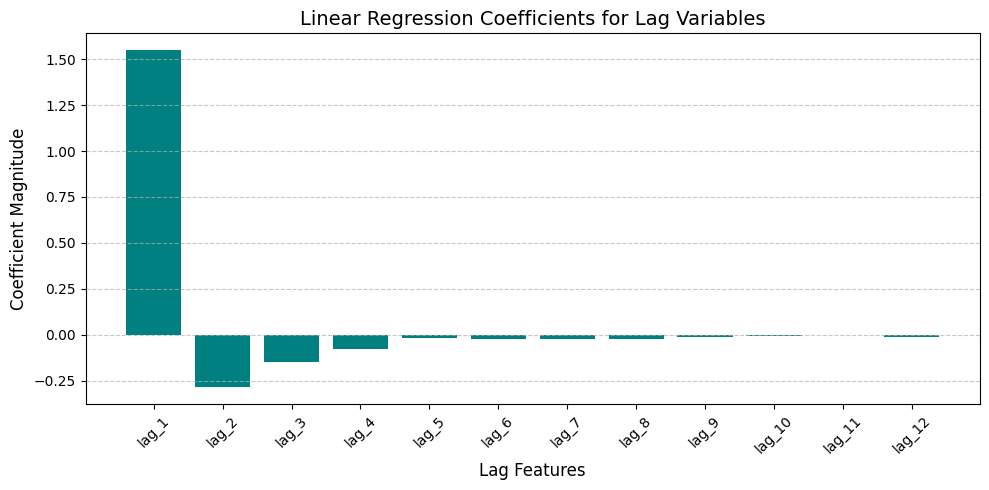

Time step 3 (predicting 15 minutes ahead) - ARX RMSE: 18.8264
Linear Regression Coefficients (ARX Model):
lag_1: 1.6500
lag_2: -0.3433
lag_3: -0.1876
lag_4: -0.1063
lag_5: -0.0357
lag_6: -0.0331
lag_7: -0.0313
lag_8: -0.0271
lag_9: -0.0151
lag_10: -0.0043
lag_11: 0.0006
lag_12: -0.0158
normal: 0.0000
carbInput: 0.0000
insulinCarbRatio: 0.0000
bgInput: 0.0000
recommended.carb: 0.0000
recommended.net: 0.0000
recommended.correction: 0.0000
insulinSensitivityFactor: 0.0000
targetBloodGlucose: 0.0000
insulinOnBoard: 0.0000
normal_lag_1: 0.0000
normal_lag_2: 0.0000
normal_lag_3: 0.0000
normal_lag_4: 0.0000
normal_lag_5: 0.0000
normal_lag_6: 0.0000
normal_lag_7: 0.0000
normal_lag_8: 0.0000
normal_lag_9: 0.0000
normal_lag_10: 0.0000
normal_lag_11: 0.0000
normal_lag_12: 0.0000
carbInput_lag_1: 0.0000
carbInput_lag_2: 0.0000
carbInput_lag_3: 0.0000
carbInput_lag_4: 0.0000
carbInput_lag_5: 0.0000
carbInput_lag_6: 0.0000
carbInput_lag_7: 0.0000
carbInput_lag_8: 0.0000
carbInput_lag_9: 0.0000
carbI

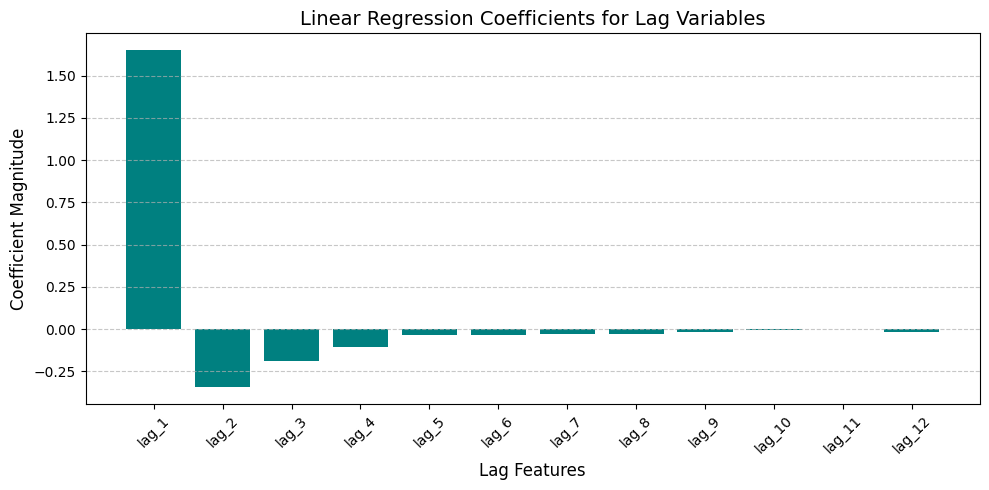

Time step 6 (predicting 30 minutes ahead) - ARX RMSE: 28.8841
Linear Regression Coefficients (ARX Model):
lag_1: 1.6426
lag_2: -0.3706
lag_3: -0.2005
lag_4: -0.1151
lag_5: -0.0428
lag_6: -0.0371
lag_7: -0.0331
lag_8: -0.0260
lag_9: -0.0207
lag_10: -0.0072
lag_11: -0.0015
lag_12: -0.0121
normal: 0.0000
carbInput: 0.0000
insulinCarbRatio: 0.0000
bgInput: 0.0000
recommended.carb: 0.0000
recommended.net: 0.0000
recommended.correction: 0.0000
insulinSensitivityFactor: 0.0000
targetBloodGlucose: 0.0000
insulinOnBoard: 0.0000
normal_lag_1: 0.0000
normal_lag_2: 0.0000
normal_lag_3: 0.0000
normal_lag_4: 0.0000
normal_lag_5: 0.0000
normal_lag_6: 0.0000
normal_lag_7: 0.0000
normal_lag_8: 0.0000
normal_lag_9: 0.0000
normal_lag_10: 0.0000
normal_lag_11: 0.0000
normal_lag_12: 0.0000
carbInput_lag_1: 0.0000
carbInput_lag_2: 0.0000
carbInput_lag_3: 0.0000
carbInput_lag_4: 0.0000
carbInput_lag_5: 0.0000
carbInput_lag_6: 0.0000
carbInput_lag_7: 0.0000
carbInput_lag_8: 0.0000
carbInput_lag_9: 0.0000
carb

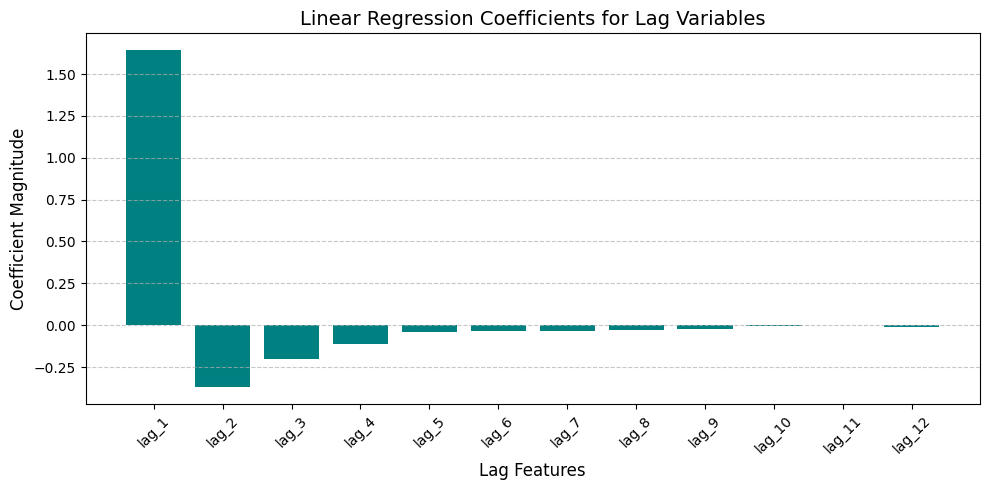

Time step 9 (predicting 45 minutes ahead) - ARX RMSE: 36.9353
Linear Regression Coefficients (ARX Model):
lag_1: 1.5697
lag_2: -0.3696
lag_3: -0.1997
lag_4: -0.1142
lag_5: -0.0414
lag_6: -0.0422
lag_7: -0.0354
lag_8: -0.0273
lag_9: -0.0186
lag_10: -0.0067
lag_11: -0.0000
lag_12: -0.0123
normal: 0.0000
carbInput: 0.0000
insulinCarbRatio: 0.0000
bgInput: 0.0000
recommended.carb: 0.0000
recommended.net: 0.0000
recommended.correction: 0.0000
insulinSensitivityFactor: 0.0000
targetBloodGlucose: 0.0000
insulinOnBoard: 0.0000
normal_lag_1: 0.0000
normal_lag_2: 0.0000
normal_lag_3: 0.0000
normal_lag_4: 0.0000
normal_lag_5: 0.0000
normal_lag_6: 0.0000
normal_lag_7: 0.0000
normal_lag_8: 0.0000
normal_lag_9: 0.0000
normal_lag_10: 0.0000
normal_lag_11: 0.0000
normal_lag_12: 0.0000
carbInput_lag_1: 0.0000
carbInput_lag_2: 0.0000
carbInput_lag_3: 0.0000
carbInput_lag_4: 0.0000
carbInput_lag_5: 0.0000
carbInput_lag_6: 0.0000
carbInput_lag_7: 0.0000
carbInput_lag_8: 0.0000
carbInput_lag_9: 0.0000
carb

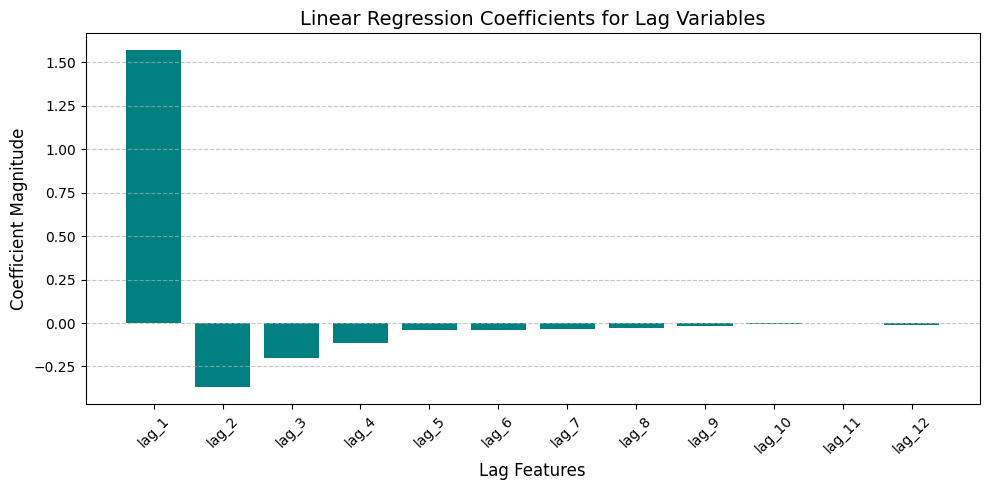

Time step 12 (predicting 60 minutes ahead) - ARX RMSE: 43.2042


In [ ]:
# Train ARX models for different time steps and evaluate
results_arx = {}
for step in time_steps:
    model, rmse = train_arx_model(merged_data, step)
    results_arx[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"Time step {step} (predicting {step*5} minutes ahead) - ARX RMSE: {rmse:.4f}")

In [ ]:
# Modify train_arx_model function to include all lagged features
import matplotlib.pyplot as plt
import numpy as np

def train_arx_model(data, target_step):
    # Prepare inputs (X) - using lag features from both mg/dl and Bolus data
    lag_columns = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
                  [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
    X = data[lag_columns].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Extract coefficients and intercept
    coefficients = model.coef_
    intercept = model.intercept_

    # Display the coefficients
    print("Linear Regression Coefficients (ARX Model):")
    feature_names = merged_data.drop(columns=['date', 'mg/dl']).columns
    for feature, coef in zip(feature_names, coefficients):
        print(f"{feature}: {coef:.4f}")
    print(f"Intercept: {intercept:.4f}")

    # Generate a bar chart for lag variables only
    lag_indices = [i for i, feature in enumerate(feature_names) if feature.startswith('lag_')]
    lag_features = feature_names[lag_indices]
    lag_coefficients = coefficients[lag_indices]

    plt.figure(figsize=(10, 5))
    plt.bar(lag_features, lag_coefficients, color='teal')
    plt.xlabel('Lag Features', fontsize=12)
    plt.ylabel('Coefficient Magnitude', fontsize=12)
    plt.title('Linear Regression Coefficients for Lag Variables', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return model, rmse


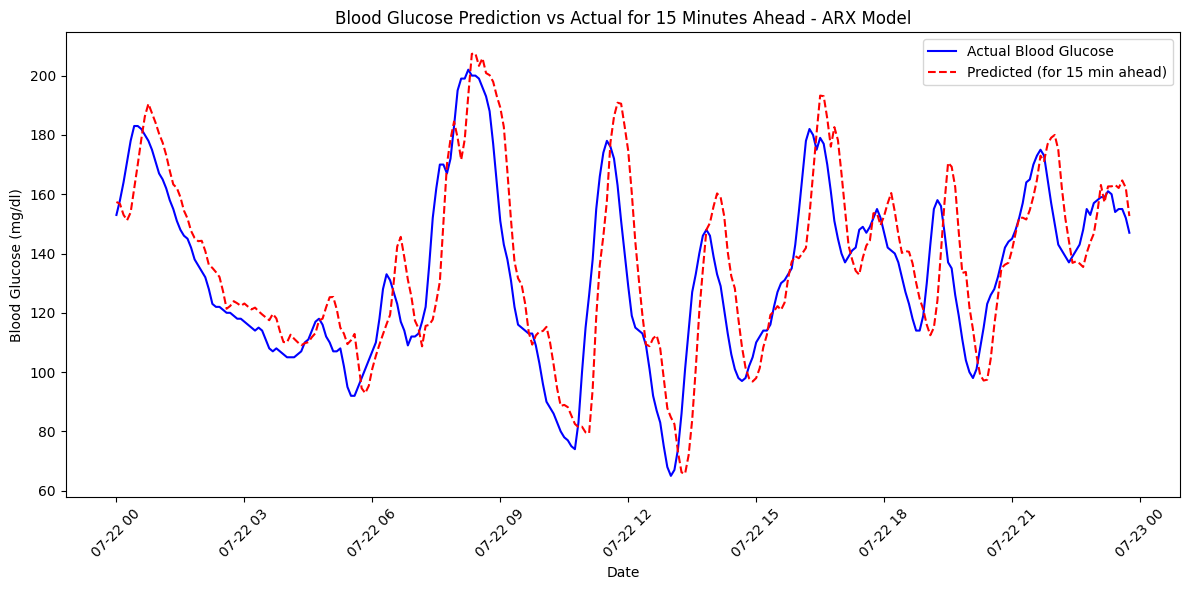

In [ ]:
import matplotlib.pyplot as plt

# Function to make predictions for a specific week and plot them using the ARX model
def plot_predictions_for_week_arx(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction using lag features from both CGM and Bolus data
    lag_columns = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
                  [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
    X_week = week_data[lag_columns].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Predicted (for {target_step*5} min ahead)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead - ARX Model')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Replace with desired dates for plotting
start_date = '2021-07-22'
end_date = '2021-07-23'
plot_predictions_for_week_arx(merged_data[train_size:], results_arx['15 min ahead']['Model'], 3, start_date, end_date)


Recursive AR Model

In [ ]:
# Recursive forecasting function for the AR model
def recursive_forecast_ar_model(data, model, num_steps):
    # Initialize a list to store predictions
    predictions = []

    # Get the last 'num_lags' lag values from the data for initial input
    last_known_data = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].iloc[-1].values

    # Generate recursive predictions
    for _ in range(num_steps):
        # Reshape last known data to fit model input format
        next_input = last_known_data.reshape(1, -1)

        # Predict the next step
        next_pred = model.predict(next_input)[0]
        predictions.append(next_pred)

        # Update the input data by adding the new prediction and dropping the oldest value
        last_known_data = np.roll(last_known_data, -1)  # Shift values left
        last_known_data[-1] = next_pred  # Add new prediction as the latest lag

    return predictions

In [ ]:
# Function to train the AR model on 1-step-ahead predictions
def train_single_step_ar_model(data):
    # Prepare inputs (X) and target (y) for single step
    X = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y = data['mg/dl'].shift(-1).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions on the test set (1-step-ahead for evaluation)
    y_pred = model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return model, rmse

In [ ]:
# Train the single-step AR model and evaluate
single_step_model, single_step_rmse = train_single_step_ar_model(cgm_data)
print(f"Single-step prediction model - RMSE: {single_step_rmse:.4f}")

# Perform recursive forecasting for different time steps
future_steps = [3, 6, 9, 12]  # 15, 30, 45, 60 minutes ahead
recursive_results = {}

for step in future_steps:
    # Recursive prediction
    predictions = recursive_forecast_ar_model(cgm_data, single_step_model, step)
    recursive_results[f'{step*5} min ahead'] = predictions
    print(f"Recursive prediction for {step*5} minutes ahead: {predictions}")

Single-step prediction model - RMSE: 10.6876
Recursive prediction for 15 minutes ahead: [126.17805109733817, 127.68015956863383, 120.76163207918681]
Recursive prediction for 30 minutes ahead: [126.17805109733817, 127.68015956863383, 120.76163207918681, 109.52853483526249, 109.00482971243424, 128.98632079699058]
Recursive prediction for 45 minutes ahead: [126.17805109733817, 127.68015956863383, 120.76163207918681, 109.52853483526249, 109.00482971243424, 128.98632079699058, 152.45971484822644, 162.17968482857108, 128.94240587123528]
Recursive prediction for 60 minutes ahead: [126.17805109733817, 127.68015956863383, 120.76163207918681, 109.52853483526249, 109.00482971243424, 128.98632079699058, 152.45971484822644, 162.17968482857108, 128.94240587123528, 138.44187680436852, 124.718144110842, 138.22606406267354]


In [ ]:
from sklearn.metrics import mean_squared_error

# Function to calculate RMSE for each recursive forecast
def calculate_recursive_rmse(data, model, num_steps):
    # Initialize list to store RMSE values
    rmse_values = {}

    # Iterate through each time step to calculate RMSE
    for step in num_steps:
        # Get the recursive predictions for the current step
        predictions = recursive_forecast_ar_model(data, model, step)

        # Get the actual values corresponding to this step
        actual_values = data['mg/dl'].shift(-step).dropna().values[:len(predictions)]

        # Calculate RMSE for this time step
        rmse = np.sqrt(mean_squared_error(actual_values, predictions))
        rmse_values[f'{step*5} min ahead'] = rmse
        print(f"RMSE for recursive forecast {step*5} minutes ahead: {rmse:.4f}")

    return rmse_values

# Calculate RMSE for recursive forecasts on the test set
recursive_rmse = calculate_recursive_rmse(cgm_data[train_size:], single_step_model, future_steps)


RMSE for recursive forecast 15 minutes ahead: 26.7744
RMSE for recursive forecast 30 minutes ahead: 38.2271
RMSE for recursive forecast 45 minutes ahead: 30.4010
RMSE for recursive forecast 60 minutes ahead: 29.9050


LASSO Regression

In [ ]:
from sklearn.linear_model import Lasso

# Function to train and evaluate a Lasso regression model for a specified prediction step
def train_lasso_model(data, target_step, alpha=0.1, max_iter=5000):
    # Prepare inputs (X) and target (y)
    X = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the Lasso model with specified alpha (regularization strength)
    lasso_model = Lasso(alpha=alpha, max_iter=max_iter)
    lasso_model.fit(X_train, y_train)

    # Make predictions
    y_pred = lasso_model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return lasso_model, rmse

In [ ]:
# Train and evaluate Lasso models for different time steps
lasso_results = {}
for step in time_steps:
    model, rmse = train_lasso_model(cgm_data, step, alpha=0.1, max_iter=5000)
    lasso_results[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"Lasso regression for {step*5} minutes ahead - RMSE: {rmse:.4f}")

Lasso regression for 15 minutes ahead - RMSE: 18.8339
Lasso regression for 30 minutes ahead - RMSE: 28.8946
Lasso regression for 45 minutes ahead - RMSE: 36.9436
Lasso regression for 60 minutes ahead - RMSE: 43.2089


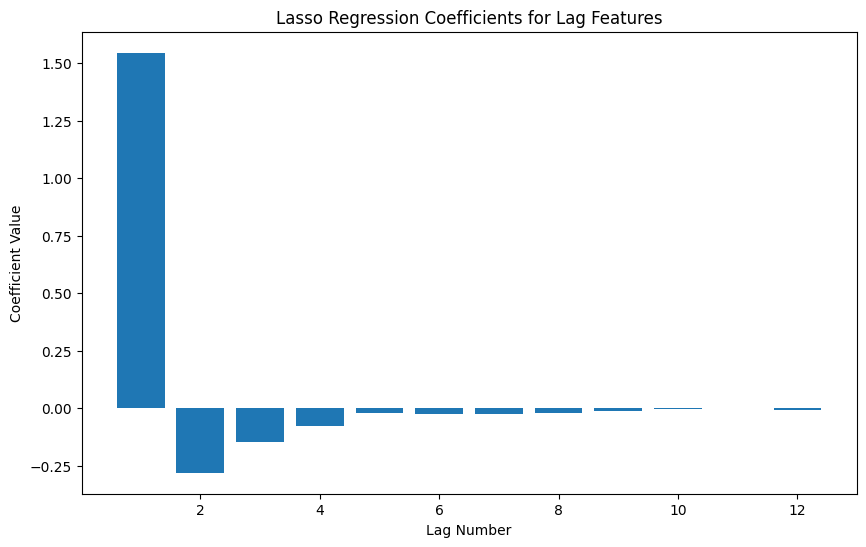

In [ ]:
# Optional: Visualize the coefficients
import matplotlib.pyplot as plt

def plot_lasso_coefficients(model, num_lags):
    coefficients = model.coef_
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, num_lags + 1), coefficients)
    plt.xlabel('Lag Number')
    plt.ylabel('Coefficient Value')
    plt.title('Lasso Regression Coefficients for Lag Features')
    plt.show()

# Plot Lasso coefficients for one of the models
plot_lasso_coefficients(lasso_results['15 min ahead']['Model'], num_lags)

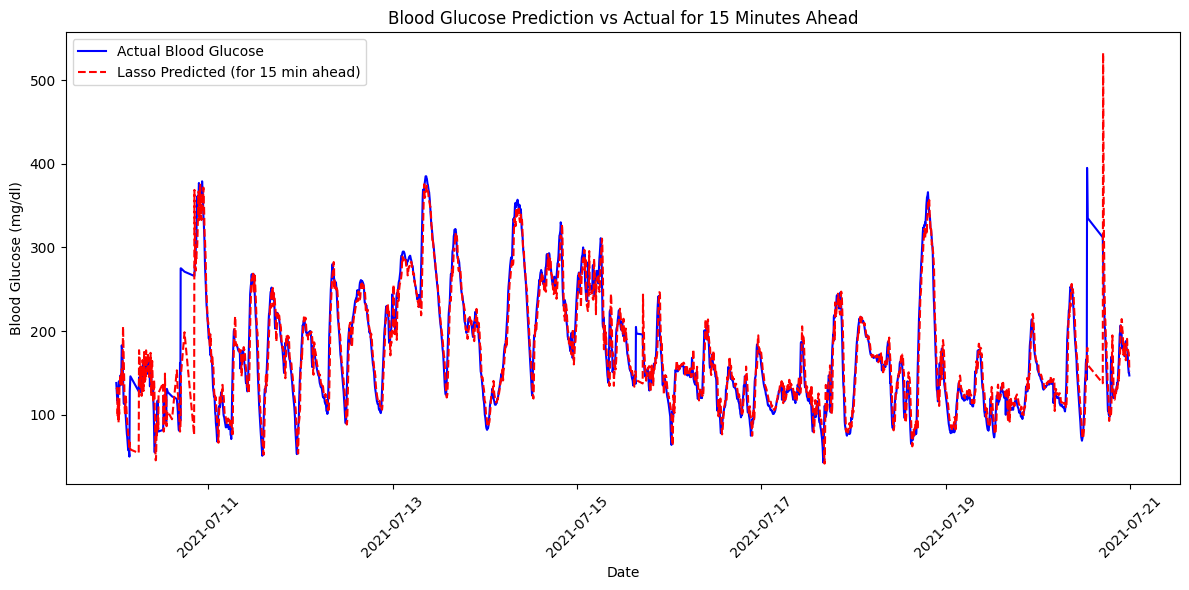

In [ ]:
import matplotlib.pyplot as plt

# Function to make predictions for a specific week and plot them
def plot_lasso_predictions_for_week(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Lasso Predicted (for {target_step*5} min ahead)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage with Lasso model and specific date range
start_date = '2021-07-10'
end_date = '2021-07-21'
plot_lasso_predictions_for_week(cgm_data[train_size:], lasso_results['15 min ahead']['Model'], 3, start_date, end_date)


Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

# Function to train and evaluate a Ridge regression model for a specified prediction step
def train_ridge_model(data, target_step, alpha=1.0):
    # Prepare inputs (X) and target (y)
    X = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the Ridge model with specified alpha (regularization strength)
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)

    # Make predictions
    y_pred = ridge_model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return ridge_model, rmse

# Train and evaluate Ridge models for different time steps
ridge_results = {}
alpha_value = 1.0  # Adjust alpha as needed for regularization strength
for step in time_steps:
    model, rmse = train_ridge_model(cgm_data, step, alpha=alpha_value)
    ridge_results[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"Ridge regression for {step*5} minutes ahead - RMSE: {rmse:.4f}")


Ridge regression for 15 minutes ahead - RMSE: 18.8309
Ridge regression for 30 minutes ahead - RMSE: 28.8924
Ridge regression for 45 minutes ahead - RMSE: 36.9419
Ridge regression for 60 minutes ahead - RMSE: 43.2075


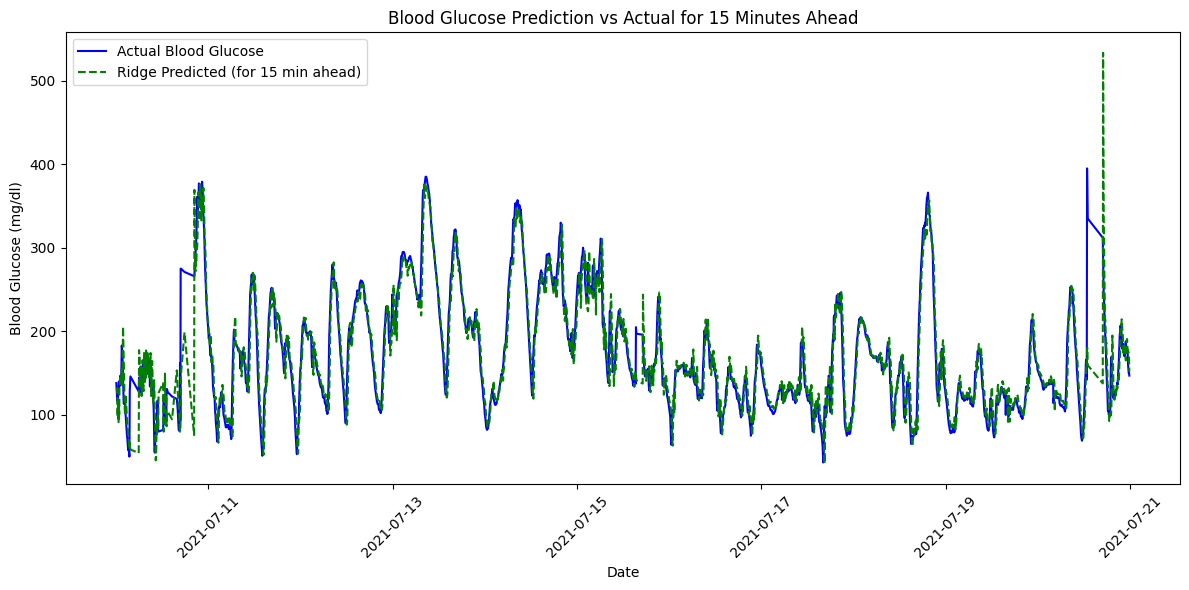

In [ ]:
# Function to make predictions for a specific week and plot them using Ridge model
def plot_ridge_predictions_for_week(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Ridge Predicted (for {target_step*5} min ahead)', color='green', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage with Ridge model and specific date range
start_date = '2021-07-10'
end_date = '2021-07-21'
plot_ridge_predictions_for_week(cgm_data[train_size:], ridge_results['15 min ahead']['Model'], 3, start_date, end_date)


Elastic Net Regression

In [ ]:
from sklearn.linear_model import ElasticNet

# Function to train and evaluate ElasticNet model
def train_elastic_net_model(data, target_step, alpha=1.0, l1_ratio=0.5):
    # Prepare inputs (X) and target (y)
    X = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the ElasticNet model
    elastic_net_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    elastic_net_model.fit(X_train, y_train)

    # Make predictions
    y_pred = elastic_net_model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return elastic_net_model, rmse

# Train and evaluate ElasticNet models for different time steps
elastic_net_results = {}
alpha_value = 1.0  # Regularization strength (larger values => more regularization)
l1_ratio_value = 0.5  # Mix ratio between Lasso (L1) and Ridge (L2) regularization
for step in time_steps:
    model, rmse = train_elastic_net_model(cgm_data, step, alpha=alpha_value, l1_ratio=l1_ratio_value)
    elastic_net_results[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"ElasticNet for {step*5} minutes ahead - RMSE: {rmse:.4f}")


ElasticNet for 15 minutes ahead - RMSE: 18.8572
ElasticNet for 30 minutes ahead - RMSE: 28.9136
ElasticNet for 45 minutes ahead - RMSE: 36.9584
ElasticNet for 60 minutes ahead - RMSE: 43.2202


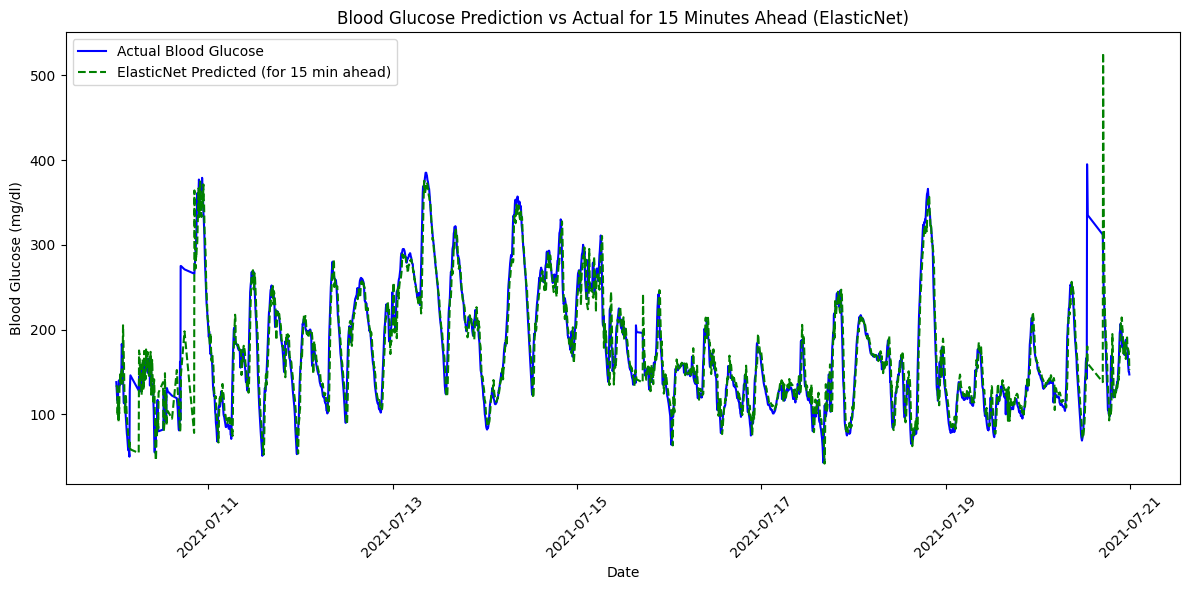

In [ ]:
# Function to plot ElasticNet predictions for a specific week
def plot_elastic_net_predictions_for_week(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'ElasticNet Predicted (for {target_step*5} min ahead)', color='green', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead (ElasticNet)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage with ElasticNet model and specific date range
start_date = '2021-07-10'
end_date = '2021-07-21'
plot_elastic_net_predictions_for_week(cgm_data[train_size:], elastic_net_results['15 min ahead']['Model'], 3, start_date, end_date)


Huber

In [ ]:
from sklearn.linear_model import HuberRegressor

# Function to train and evaluate Huber regression model
def train_huber_model(data, target_step, epsilon=1.35):
    # Prepare inputs (X) and target (y)
    X = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the Huber regression model
    huber_model = HuberRegressor(epsilon=epsilon, max_iter=1000)
    huber_model.fit(X_train, y_train)

    # Make predictions
    y_pred = huber_model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return huber_model, rmse

# Train and evaluate Huber models for different time steps
huber_results = {}
epsilon_value = 1.35  # Huber loss function parameter (controls the threshold between quadratic and linear loss)
for step in time_steps:
    model, rmse = train_huber_model(cgm_data, step, epsilon=epsilon_value)
    huber_results[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"Huber for {step*5} minutes ahead - RMSE: {rmse:.4f}")


Huber for 15 minutes ahead - RMSE: 18.7570
Huber for 30 minutes ahead - RMSE: 29.0361
Huber for 45 minutes ahead - RMSE: 37.2799
Huber for 60 minutes ahead - RMSE: 43.6411


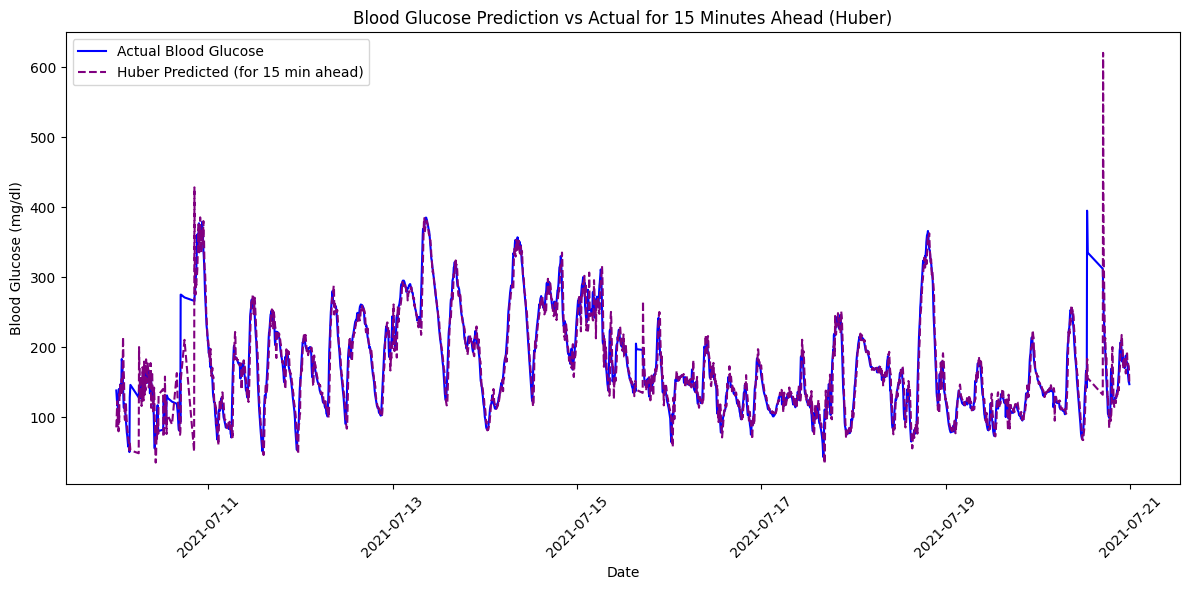

In [ ]:
# Function to plot Huber predictions for a specific week
def plot_huber_predictions_for_week(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Huber Predicted (for {target_step*5} min ahead)', color='purple', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead (Huber)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage with Huber model and specific date range
start_date = '2021-07-10'
end_date = '2021-07-21'
plot_huber_predictions_for_week(cgm_data[train_size:], huber_results['15 min ahead']['Model'], 3, start_date, end_date)


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Function to train and evaluate Random Forest model
def train_rf_model(data, target_step, n_estimators=100, max_depth=None, random_state=42):
    # Prepare inputs (X) and target (y)
    X = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rf_model, rmse

# Train and evaluate Random Forest models for different time steps
rf_results = {}
for step in time_steps:
    model, rmse = train_rf_model(cgm_data, step, n_estimators=100, max_depth=10)
    rf_results[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"Random Forest for {step*5} minutes ahead - RMSE: {rmse:.4f}")


Random Forest for 15 minutes ahead - RMSE: 18.0192
Random Forest for 30 minutes ahead - RMSE: 27.7374
Random Forest for 45 minutes ahead - RMSE: 35.6545
Random Forest for 60 minutes ahead - RMSE: 41.9177


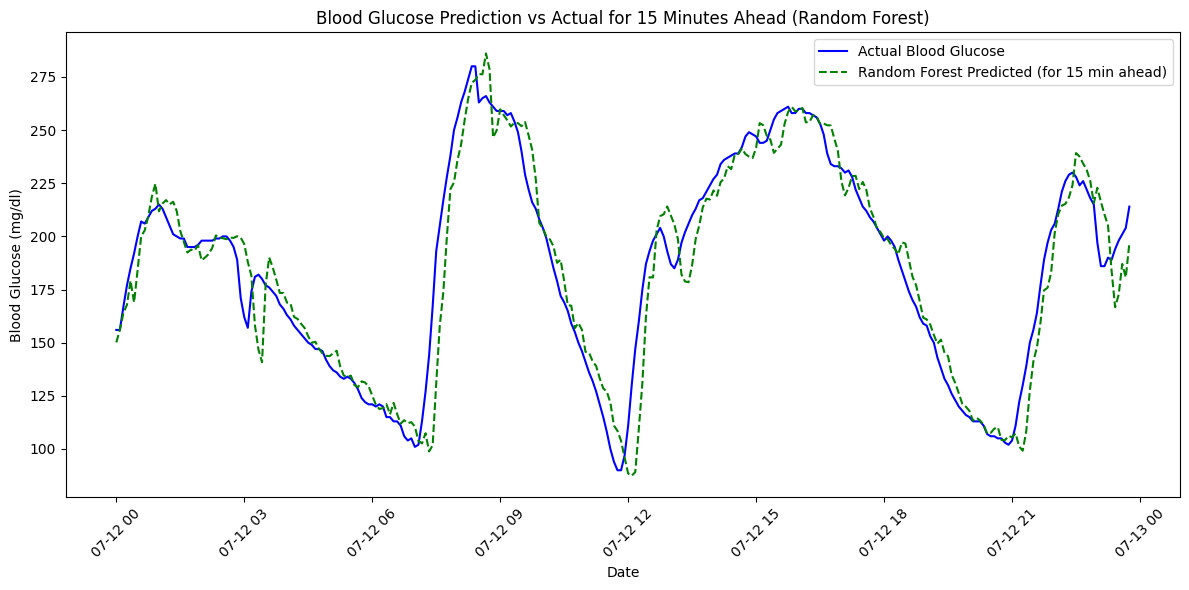

In [ ]:
# Function to plot Random Forest predictions for a specific week
def plot_rf_predictions_for_week(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Random Forest Predicted (for {target_step*5} min ahead)', color='green', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead (Random Forest)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage with Random Forest model and specific date range
start_date = '2021-07-12'
end_date = '2021-07-13'
plot_rf_predictions_for_week(cgm_data[train_size:], rf_results['15 min ahead']['Model'], 3, start_date, end_date)


XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Function to train and evaluate XGBoost model
def train_xgb_model(data, target_step, num_boost_round=100, learning_rate=0.1, max_depth=30, random_state=42):
    # Prepare inputs (X) and target (y)
    X = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set parameters for XGBoost
    params = {
        'objective': 'reg:squarederror',  # Regression task (squared error loss)
        'eval_metric': 'rmse',            # Metric to evaluate model
        'max_depth': max_depth,           # Depth of the trees
        'learning_rate': learning_rate,  # Step size shrinkage
        'random_state': random_state,    # For reproducibility
    }

    # Train the XGBoost model
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

    # Make predictions
    y_pred = model.predict(dtest)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return model, rmse

# Train and evaluate XGBoost models for different time steps
xgb_results = {}
for step in time_steps:
    model, rmse = train_xgb_model(cgm_data, step, num_boost_round=100, learning_rate=0.1, max_depth=10)
    xgb_results[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"XGBoost for {step*5} minutes ahead - RMSE: {rmse:.4f}")


XGBoost for 15 minutes ahead - RMSE: 17.8230
XGBoost for 30 minutes ahead - RMSE: 27.5559
XGBoost for 45 minutes ahead - RMSE: 35.5219
XGBoost for 60 minutes ahead - RMSE: 41.8985


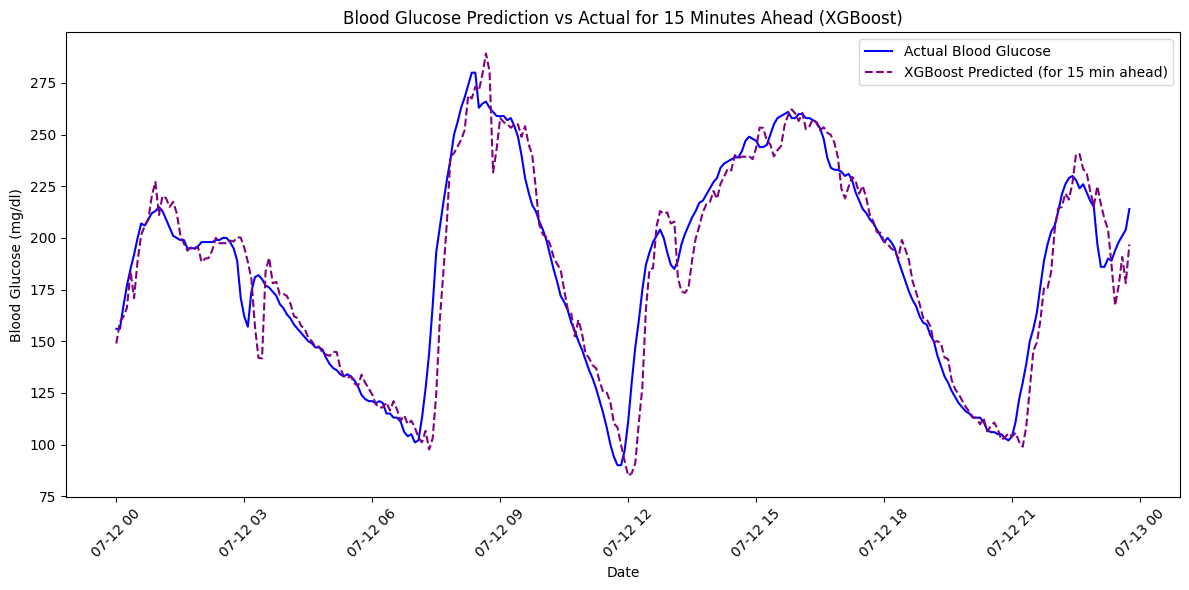

In [ ]:
# Function to plot XGBoost predictions for a specific week
def plot_xgb_predictions_for_week(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(xgb.DMatrix(X_week))

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'XGBoost Predicted (for {target_step*5} min ahead)', color='purple', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead (XGBoost)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage with XGBoost model and specific date range
start_date = '2021-07-12'
end_date = '2021-07-13'
plot_xgb_predictions_for_week(cgm_data[train_size:], xgb_results['15 min ahead']['Model'], 3, start_date, end_date)


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to train and evaluate XGBoost model with ARX features
def train_xgb_arx_model(data, target_step, num_boost_round=100, learning_rate=0.1, max_depth=10, random_state=42):
    # Prepare inputs (X) and target (y)
    # Use all lagged features (CGM + Bolus variables)
    feature_columns = [col for col in data.columns if col.startswith('lag_') or '_lag_' in col]
    X = data[feature_columns].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set parameters for XGBoost
    params = {
        'objective': 'reg:squarederror',  # Regression task (squared error loss)
        'eval_metric': 'rmse',            # Metric to evaluate model
        'max_depth': max_depth,           # Depth of the trees
        'learning_rate': learning_rate,   # Step size shrinkage
        'random_state': random_state,     # For reproducibility
    }

    # Train the XGBoost model
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

    # Make predictions
    y_pred = model.predict(dtest)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return model, rmse

# Train and evaluate XGBoost models for different time steps
xgb_arx_results = {}
for step in time_steps:
    model, rmse = train_xgb_arx_model(merged_data, step, num_boost_round=100, learning_rate=0.1, max_depth=10)
    xgb_arx_results[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"XGBoost (ARX) for {step*5} minutes ahead - RMSE: {rmse:.4f}")

XGBoost (ARX) for 15 minutes ahead - RMSE: 17.8321
XGBoost (ARX) for 30 minutes ahead - RMSE: 27.5621
XGBoost (ARX) for 45 minutes ahead - RMSE: 35.5331
XGBoost (ARX) for 60 minutes ahead - RMSE: 41.9025
